In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lsst.ts.wep.WfEstimator import WfEstimator
from lsst.ts.wep.Utility import DefocalType, getConfigDir

import batoid
import wfsim
import galsim

/astro/store/epyc/projects/lsst_comm/lsstinstall/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
band = "r"

# load the fiducial telescope
telescope = batoid.Optic.fromYaml(f"LSST_{band}.yaml")

# create the wfsim simulator
bandpass = galsim.Bandpass(f"LSST_{band}.dat", wave_type="nm")
observation = {
        'zenith': 30 * galsim.degrees,
        'raw_seeing': 0.7 * galsim.arcsec,  # zenith 500nm seeing
        'wavelength': bandpass.effective_wavelength,
        'exptime': 15.0,  # seconds
        'temperature': 293.,  # Kelvin
        'pressure': 69.,  #kPa
        'H2O_pressure': 1.0  #kPa
    }
atm_kwargs = {
    'screen_size': 819.2,
    'screen_scale': 0.1,
    'nproc': 6  # create screens in parallel using this many CPUs
} 
simulator = wfsim.SimpleSimulator(
    observation,
    atm_kwargs,
    telescope,
    bandpass,
    name="R00_SW0",
    rng=np.random.default_rng(0),
)

In [13]:
detectorLocations = {
    # bottom left
    "R00": (-0.02075, -0.02075),
    "R00_SW0": (-0.02075, -0.02075),
    "R00_SW1": (-0.02075, -0.02075),
    # top left
    "R40": (-0.02075, +0.02075),
    "R40_SW0": (-0.02075, +0.02075),
    "R40_SW1": (-0.02075, +0.02075),
    # bottom right
    "R04": (+0.02075, -0.02075),
    "R04_SW0": (+0.02075, -0.02075),
    "R04_SW1": (+0.02075, -0.02075),
    # top right
    "R44": (+0.02075, +0.02075),
    "R44_SW0": (+0.02075, +0.02075),
    "R44_SW1": (+0.02075, +0.02075),
}

In [29]:
def plot(stampExtra, stampIntra, zkEst, zkTrue, zk):
    fig, axes = plt.subplot_mosaic(
        """
        ab
        cc
        """,
        figsize=(4, 4),
        dpi=150,
    )

    axes["a"].imshow(stampIntra, origin="lower")
    axes["a"].set(title="Intra")

    axes["b"].imshow(stampExtra, origin="lower")
    axes["b"].set(title="Extra")

    zk_grid = np.arange(4, 23)
    axes["c"].plot(zk_grid, zk, ls="--", c="k", label="input")
    axes["c"].plot(zk_grid, zkTrue, ls="--", c="C1", label="batoid OPD")
    axes["c"].plot(zk_grid, zkEst, label="ts_wep")
    axes["c"].legend(fontsize=8)
    axes["c"].set(xticks=np.arange(4, 23, 2), xlabel="Noll index", ylabel="$\mu m$")
    plt.show()

def check_consistency(zk, thx1, thy1, thx2, thy2, seed = 0):
    
    rng = np.random.default_rng(seed)
    
    # determine the chip
    if thx1 > 0:
        if thy1 > 0:
            chip = "R44"
        else:
            chip = "R04"
    else:
        if thy1 > 0:
            chip = "R40"
        else:
            chip = "R00"
    
    # create the perturbed telescope
    R_outer = telescope.pupilSize / 2
    R_inner = R_outer * telescope.pupilObscuration
    phase = batoid.Zernike(
        np.pad(zk, pad_width=(4,0), mode='constant') * 1e-6,
        R_outer=R_outer,
        R_inner=R_inner,
    )
    perturbed = batoid.CompoundOptic(
            (
                batoid.optic.OPDScreen(
                    batoid.Plane(),
                    phase,
                    name="PhaseScreen",
                    obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                    coordSys=telescope.stopSurface.coordSys
                ),
                *telescope.items,
            ),
            name="PerturbedLSST",
            backDist=telescope.backDist,
            pupilSize=telescope.pupilSize,
            inMedium=telescope.inMedium,
            stopSurface=telescope.stopSurface,
            sphereRadius=telescope.sphereRadius,
            pupilObscuration=telescope.pupilObscuration
    )
    
    # set some star settings
    T = 7_000 # K
    nphotons = 1_000_000
    
    # simulate the extrafocal image
    simulator.set_name(f"{chip}_SW0")
    simulator.telescope = perturbed.withGloballyShiftedOptic(
        "Detector", [0, 0, +0.0015]
    )
    simulator.add_star(thx1, thy1, wfsim.BBSED(T), nphotons, rng)

    # cut out the extrafocal stamp
    simulator._construct_wcs()
    x, y = np.array(simulator.wcs.radecToxy(thx1, thy1, galsim.radians))
    x = int(x - simulator.image.xmin)
    y = int(y - simulator.image.ymin)
    stampExtra = simulator.image.array[y-80:y+80, x-80:x+80]
    
    # simulate the intrafocal image
    simulator.set_name(f"{chip}_SW1")
    simulator.telescope = perturbed.withGloballyShiftedOptic(
        "Detector", [0, 0, -0.0015]
    )
    simulator.add_star(thx2, thy2, wfsim.BBSED(T), nphotons, rng)

    # cut out the intrafocal stamp
    simulator._construct_wcs()
    x, y = np.array(simulator.wcs.radecToxy(thx2, thy2, galsim.radians))
    x = int(x - simulator.image.xmin)
    y = int(y - simulator.image.ymin)
    stampIntra = simulator.image.array[y-80:y+80, x-80:x+80]
    
    # setup WfEstimator
    wfEst = WfEstimator(f"{getConfigDir()}/cwfs/algo")
    wfEst.config(sizeInPix=160, units="um", algo="exp", debugLevel=1)
    wfEst.setImg(
        np.rad2deg([thx1, thy1]),
        DefocalType.Extra,
        image=stampExtra.copy(),
    )
    wfEst.setImg(
        np.rad2deg([thx2, thy2]),
        DefocalType.Intra,
        image=stampIntra.copy(),
    )
    
    # estimate the wavefront
    zkEst = -wfEst.calWfsErr()
    
    # get true OPD from batoid
    opd = batoid.zernike(
        perturbed,
        *detectorLocations[chip],
        1e-6,
        jmax=22,
    ) - batoid.zernike(
        telescope,
        *detectorLocations[chip],
        1e-6,
        jmax=22,
    )
    opd = -opd[4:]
    
    plot(stampExtra, stampIntra, zkEst, opd, zk)

In [30]:
zk0 = np.array([
    -0.72299213,
    0.6302713,
    0.7560669,
    -0.04730654,
    0.0045272,
    0.18339995,
    -0.06478361,
    -0.04139484,
    -0.03860196,
    -0.01120152,
    0.1045132,
    0.0418114,
    -0.00260616,
    0.00759261,
    0.02661733,
    -0.02901934,
    0.00955849,
    0.04420937,
    -0.00819899,
])

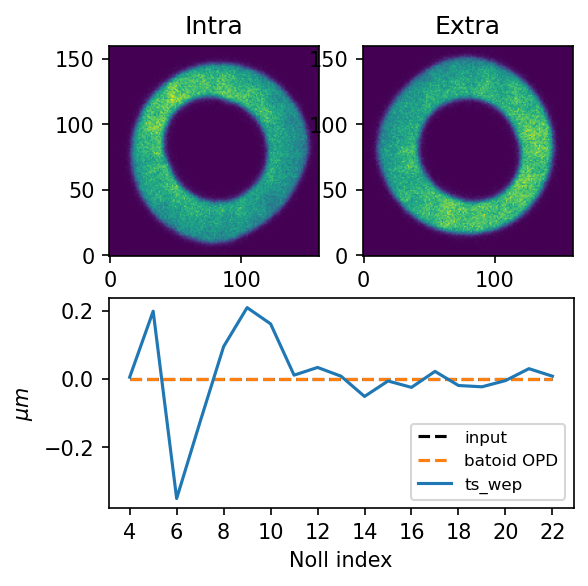

In [31]:
zk = 0.0 * zk0
check_consistency(zk, 0.019, -0.019, 0.022, -0.020)

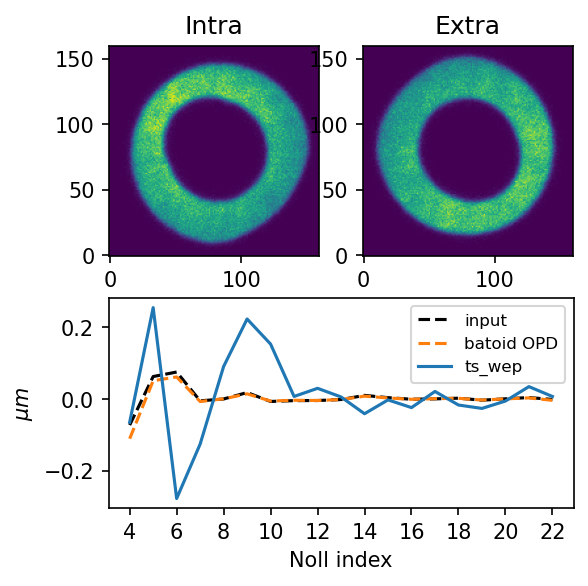

In [32]:
zk = 0.1 * zk0
check_consistency(zk, 0.019, -0.019, 0.022, -0.020)

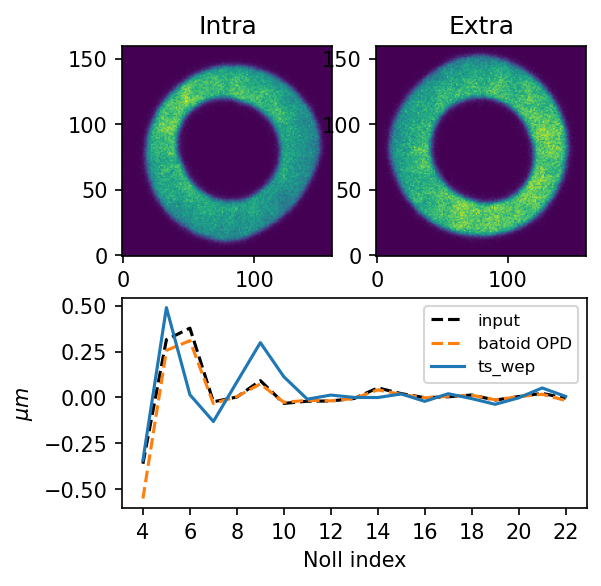

In [33]:
zk = 0.5 * zk0
check_consistency(zk, 0.019, -0.019, 0.022, -0.020)

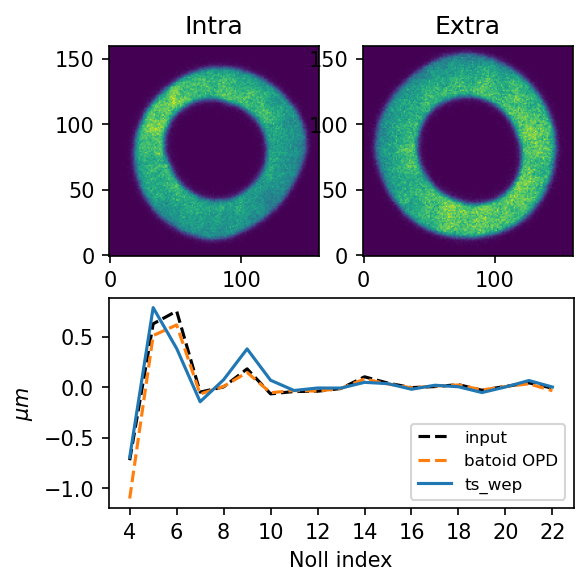

In [35]:
zk = 1.0 * zk0
check_consistency(zk, 0.019, -0.019, 0.022, -0.020)

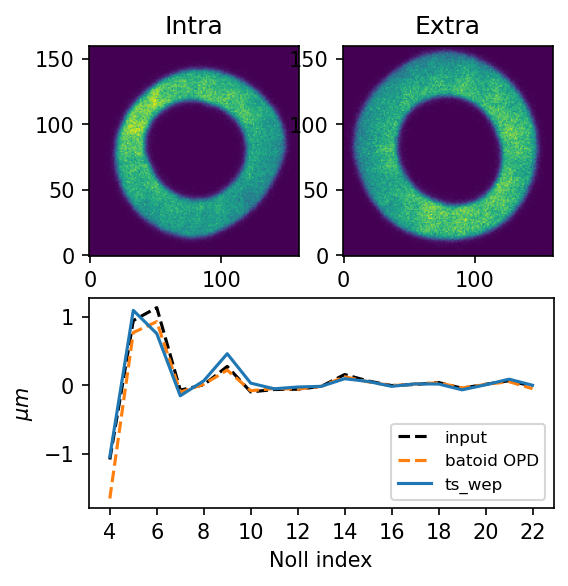

In [36]:
zk = 1.5 * zk0
check_consistency(zk, 0.019, -0.019, 0.022, -0.020)

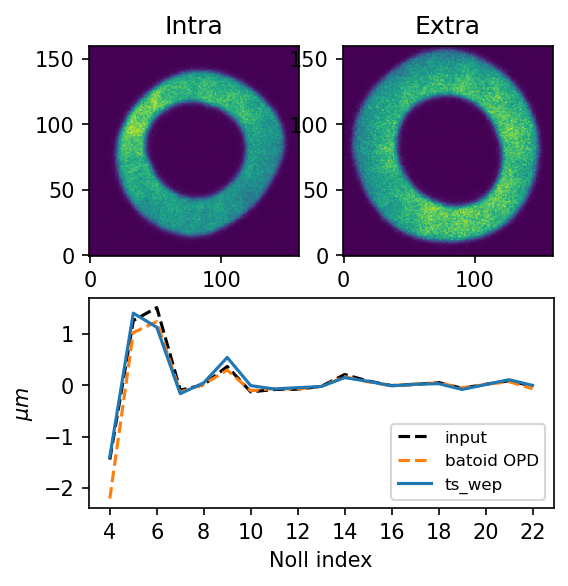

In [37]:
zk = 2.0 * zk0
check_consistency(zk, 0.019, -0.019, 0.022, -0.020)

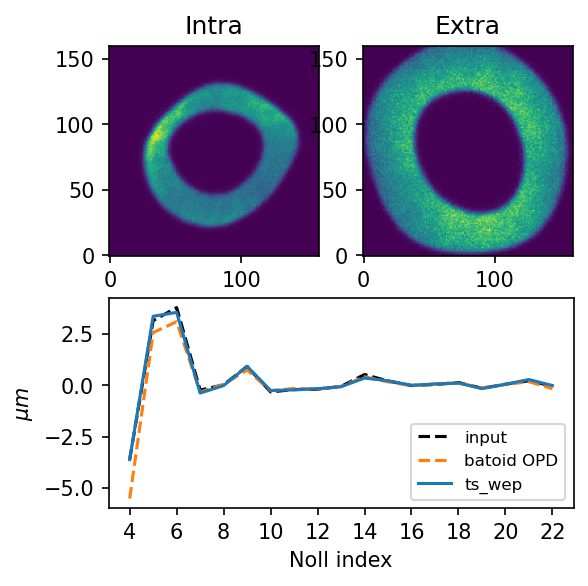

In [38]:
zk = 5.0 * zk0
check_consistency(zk, 0.019, -0.019, 0.022, -0.020)